In [1]:
!pip -q install "numpy<2" "fastai==2.8.5" "ddgs"

import warnings
warnings.filterwarnings("ignore", category=UserWarning)

In [2]:
import numpy as np, fastai
print("numpy:", np.__version__)
print("fastai:", fastai.__version__)

numpy: 1.26.4
fastai: 2.8.5


In [3]:
from ddgs import DDGS 
from fastcore.all import *
from fastai.vision.widgets import *

def search_images(keywords, max_images=200): return L(DDGS().images(keywords, max_results=max_images)).itemgot('image')

In [4]:
urls = search_images('grizzly bear photos', max_images=1)
urls[0]

'https://cdn.pixabay.com/photo/2018/06/19/04/44/grizzly-bear-3483887_1280.jpg'

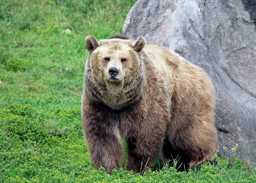

In [5]:
from fastdownload import download_url
dest = 'bear_grizzly.jpg'
download_url(urls[0], dest, show_progress=False)

from fastai.vision.all import *
im = Image.open(dest)
im.to_thumb(256,256)

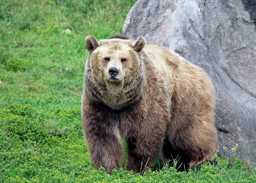

In [6]:
download_url(search_images('grizzly bear photos', max_images=1)[0], 'grizzly.jpg', show_progress=False)
Image.open('grizzly.jpg').to_thumb(256,256)

In [7]:
searches = 'grizzly bear','black bear','teddy bear'
path = Path('bears')
from time import sleep

for o in searches:
    dest = (path/o)
    dest.mkdir(exist_ok=True, parents=True)
    download_images(dest, urls=search_images(f'{o} photo'))
    sleep(10)  # Pause between searches to avoid over-loading server
    download_images(dest, urls=search_images(f'{o} sun photo'))
    sleep(10)
    download_images(dest, urls=search_images(f'{o} shade photo'))
    sleep(10)
    resize_images(path/o, max_size=400, dest=path/o)

In [8]:
failed = verify_images(get_image_files(path))
failed.map(Path.unlink)
len(failed)

13

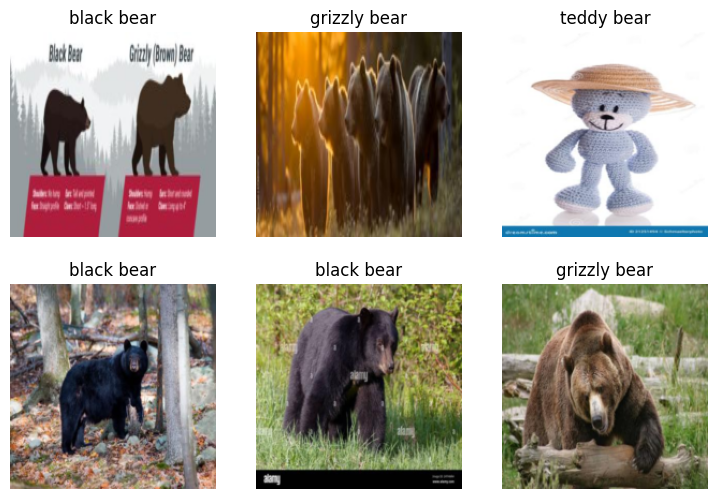

In [14]:
dls = DataBlock(
    blocks=(ImageBlock, CategoryBlock), 
    get_items=get_image_files, 
    splitter=RandomSplitter(valid_pct=0.2, seed=42),
    get_y=parent_label,
    item_tfms=[Resize(192, method='squish')]
).dataloaders(path)

dls.show_batch(max_n=6)

In [15]:

learn = vision_learner(dls, resnet18, metrics=error_rate)
learn.fine_tune(4)

epoch,train_loss,valid_loss,error_rate,time
0,1.354904,0.397132,0.108434,00:01


epoch,train_loss,valid_loss,error_rate,time
0,0.459105,0.330817,0.102410,00:01
1,0.315143,0.294594,0.090361,00:01
2,0.225476,0.257001,0.066265,00:01
3,0.175026,0.255377,0.066265,00:01


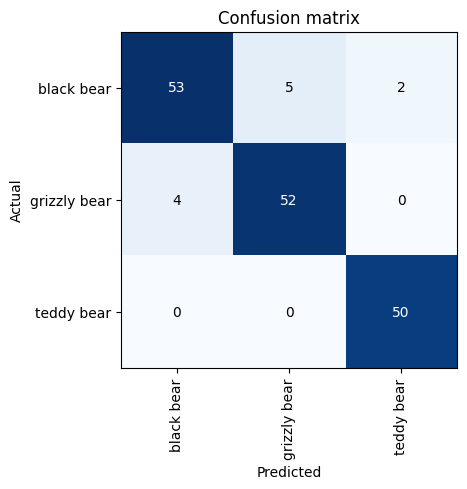

In [16]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()

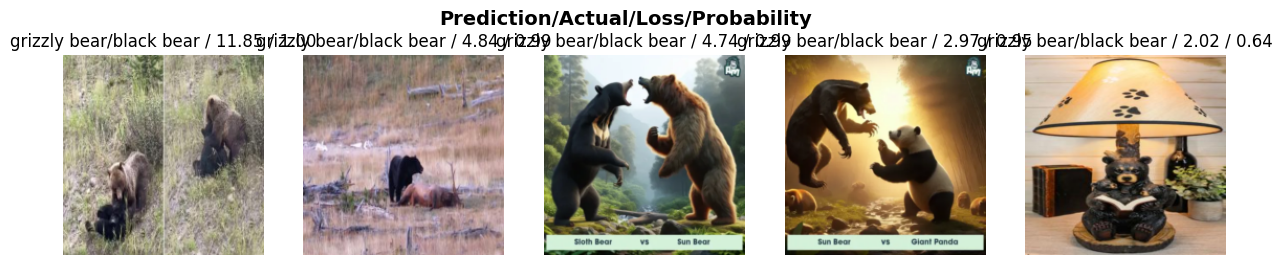

In [12]:
interp.plot_top_losses(5, nrows=1)

In [13]:
#hide_output
cleaner = ImageClassifierCleaner(learn)
cleaner

In [22]:
pred, pred_idx, probs = learn.predict(PILImage.create('bear_grizzly.jpg'))
print(f"This is a: {pred}.")
print(f"Probability it's a {pred}: {probs[pred_idx]:.4f}")

This is a: grizzly bear.
Probability it's a grizzly bear: 1.0000


In [23]:
learn.export('model_resnet18.pkl')

In [24]:

learn2 = vision_learner(dls, resnet34, metrics=error_rate)
learn2.fine_tune(3)

epoch,train_loss,valid_loss,error_rate,time
0,1.280376,0.498212,0.114458,00:02


epoch,train_loss,valid_loss,error_rate,time
0,0.393944,0.315101,0.072289,00:02
1,0.288123,0.336816,0.066265,00:02
2,0.203101,0.303570,0.066265,00:02


In [25]:
pred ,pred_idx,probs = learn2.predict(PILImage.create('bear_grizzly.jpg'))
print(f"This is a: {pred}.")
print(f"Probability it's a {pred}: {probs[pred_idx]:.4f}")

This is a: grizzly bear.
Probability it's a grizzly bear: 0.9999


In [26]:
learn2.export('model_resnet34.pkl')